In [1]:
%matplotlib notebook
import spectral
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
import warnings
warnings.filterwarnings('ignore')

1. Simple triangle network

In [2]:
#class for Nonlinear Schrödinger Network
class NSE:

    def __init__(self, domain, u1, u2, u3):
        self.u1 = u1
        self.u2 = u2
        self.u3 = u3
        self.domain = domain
        self.dtype = dtype = np.complex128
        self.ux1 = spectral.Field(domain, dtype=dtype)
        self.ux2 = spectral.Field(domain, dtype=dtype)
        self.ux3 = spectral.Field(domain, dtype=dtype)
        self.u1_RHS = spectral.Field(domain, dtype=dtype)
        self.u2_RHS = spectral.Field(domain, dtype=dtype)
        self.u3_RHS = spectral.Field(domain, dtype=dtype)
        self.ux1_RHS = spectral.Field(domain, dtype=dtype)
        self.ux2_RHS = spectral.Field(domain, dtype=dtype)
        self.ux3_RHS = spectral.Field(domain, dtype=dtype)
        
        self.problem = spectral.InitialValueProblem(domain, [u1,self.ux1,u2,self.ux2,u3,self.ux3], [self.u1_RHS, self.ux1_RHS,
                                                                                     self.u2_RHS, self.ux2_RHS,
                                                                                     self.u3_RHS, self.ux3_RHS],
                                                    num_BCs=6, dtype=np.complex128)
        
        prob = self.problem.pencils[0]
        
        self.N = N = domain.bases[0].N
        Z = np.zeros((N, N))
        
        diag = np.arange(N-1)+1
        D = sparse.diags(diag, offsets=1)
        length=domain.bases[0].interval[1]-domain.bases[0].interval[0]
        D = (2/length)*D
        
        self.D = D

        diag0 = np.ones(N)/2
        diag0[0] = 1
        diag2 = -np.ones(N-2)/2
        self.C = C = sparse.diags((diag0, diag2), offsets=(0,2))
        
        # M matrix
        M = sparse.csr_matrix((6*N+6,6*N+6),dtype=np.complex128)
        M[N:2*N, :N] = 1j*C
        M[3*N:4*N, 2*N:3*N] = 1j*C
        M[5*N:6*N, 4*N:5*N] = 1j*C
        prob.M = M
        
        # L matrix
        BC_rows1 = np.zeros((1, 2*N))
        BC_rows2 = np.zeros((1, 2*N))
        BC_rows3 = np.zeros((1, 2*N))
        BC_rows4 = np.zeros((1, 2*N))
        i = np.arange(N)
        BC_rows1[0, :N] = (-1)**i
        BC_rows2[0, :N] = (+1)**i
        BC_rows3[0, N:2*N] = (-1)**i
        BC_rows4[0, N:2*N] = (+1)**i
        BC_rows = np.zeros((6, 6*N))
        
        BC_rows[0, :2*N] = BC_rows1
        BC_rows[0, 4*N:6*N] = -BC_rows2
        BC_rows[1, :2*N] = BC_rows2
        BC_rows[1, 2*N:4*N] = -BC_rows1
        BC_rows[2, 2*N:4*N] = BC_rows2
        BC_rows[2, 4*N:6*N] = -BC_rows1
        
        BC_rows[3, :2*N] = -BC_rows3
        BC_rows[3, 4*N:6*N] = BC_rows4
        BC_rows[4, :2*N] = BC_rows4
        BC_rows[4, 2*N:4*N] = -BC_rows3
        BC_rows[5, 2*N:4*N] = BC_rows4
        BC_rows[5, 4*N:6*N] = -BC_rows3
        
        

        cols = np.zeros((6*N,6))
        cols[  N-1, 0] = 1
        cols[2*N-1, 1] = 1
        cols[3*N-1, 2] = 1
        cols[4*N-1, 3] = 1
        cols[5*N-1, 4] = 1
        cols[6*N-1, 5] = 1
        corner = np.zeros((6,6))

        Z = np.zeros((N, N))
        Zlarge = np.zeros((2*N,2*N))
        L = sparse.bmat([[D, -C],
                         [Z, 0.5*D]])
        L = sparse.bmat([[      L, Zlarge,  Zlarge],
                         [ Zlarge,      L,  Zlarge],
                         [ Zlarge, Zlarge,       L]])
        L = sparse.bmat([[      L,   cols],
                         [BC_rows, corner]])
        L = L.tocsr()
        prob.L = L
        self.t = 0
        
        self.u1.require_coeff_space()
        self.ux1.require_coeff_space()
        self.ux1.data = self.D @ self.u1.data
        self.ux1.data = spla.spsolve(self.C,self.ux1.data)
        
        self.u2.require_coeff_space()
        self.ux2.require_coeff_space()
        self.ux2.data = self.D @ self.u2.data
        self.ux2.data = spla.spsolve(self.C,self.ux2.data)
        
        self.u3.require_coeff_space()
        self.ux3.require_coeff_space()
        self.ux3.data = self.D @ self.u3.data
        self.ux3.data = spla.spsolve(self.C,self.ux3.data)

    def evolve(self, timestepper, dt, num_steps):
        ts = timestepper(self.problem)
        u1 = self.u1
        ux1 = self.ux1
        ux1_RHS = self.ux1_RHS
        u2 = self.u2
        ux2 = self.ux2
        ux2_RHS = self.ux2_RHS
        u3 = self.u3
        ux3 = self.ux3
        ux3_RHS = self.ux3_RHS
        D = self.D
        BC_func = lambda t: [0, 0, 0, 0, 0, 0]

        for i in range(num_steps):
            u1.require_coeff_space()
            ux1.require_coeff_space()           
            ux1_RHS.require_coeff_space()            
            u1.require_grid_space(scales=3/2)
            ux1_RHS.require_grid_space(scales=3/2)            
            ux1_RHS.data = -u1.data*np.power(np.abs(u1.data),2)
            
            u2.require_coeff_space()
            ux2.require_coeff_space()           
            ux2_RHS.require_coeff_space()            
            u2.require_grid_space(scales=3/2)
            ux2_RHS.require_grid_space(scales=3/2)            
            ux2_RHS.data = -u2.data*np.power(np.abs(u2.data),2)
            
            u3.require_coeff_space()
            ux3.require_coeff_space()           
            ux3_RHS.require_coeff_space()            
            u3.require_grid_space(scales=3/2)
            ux3_RHS.require_grid_space(scales=3/2)            
            ux3_RHS.data = -u3.data*np.power(np.abs(u3.data),2)

            
            
            ux1_RHS.require_coeff_space()
            ux1_RHS.data = self.C @ ux1_RHS.data
            u1.require_coeff_space()
            ux1.require_coeff_space()
                        
            ux2_RHS.require_coeff_space()
            ux2_RHS.data = self.C @ ux2_RHS.data
            u2.require_coeff_space()
            ux2.require_coeff_space()
            
            ux3_RHS.require_coeff_space()
            ux3_RHS.data = self.C @ ux3_RHS.data
            u3.require_coeff_space()
            ux3.require_coeff_space()
            
            ts.step(dt, BC_func(self.t))
            self.t += dt

<IPython.core.display.Javascript object>


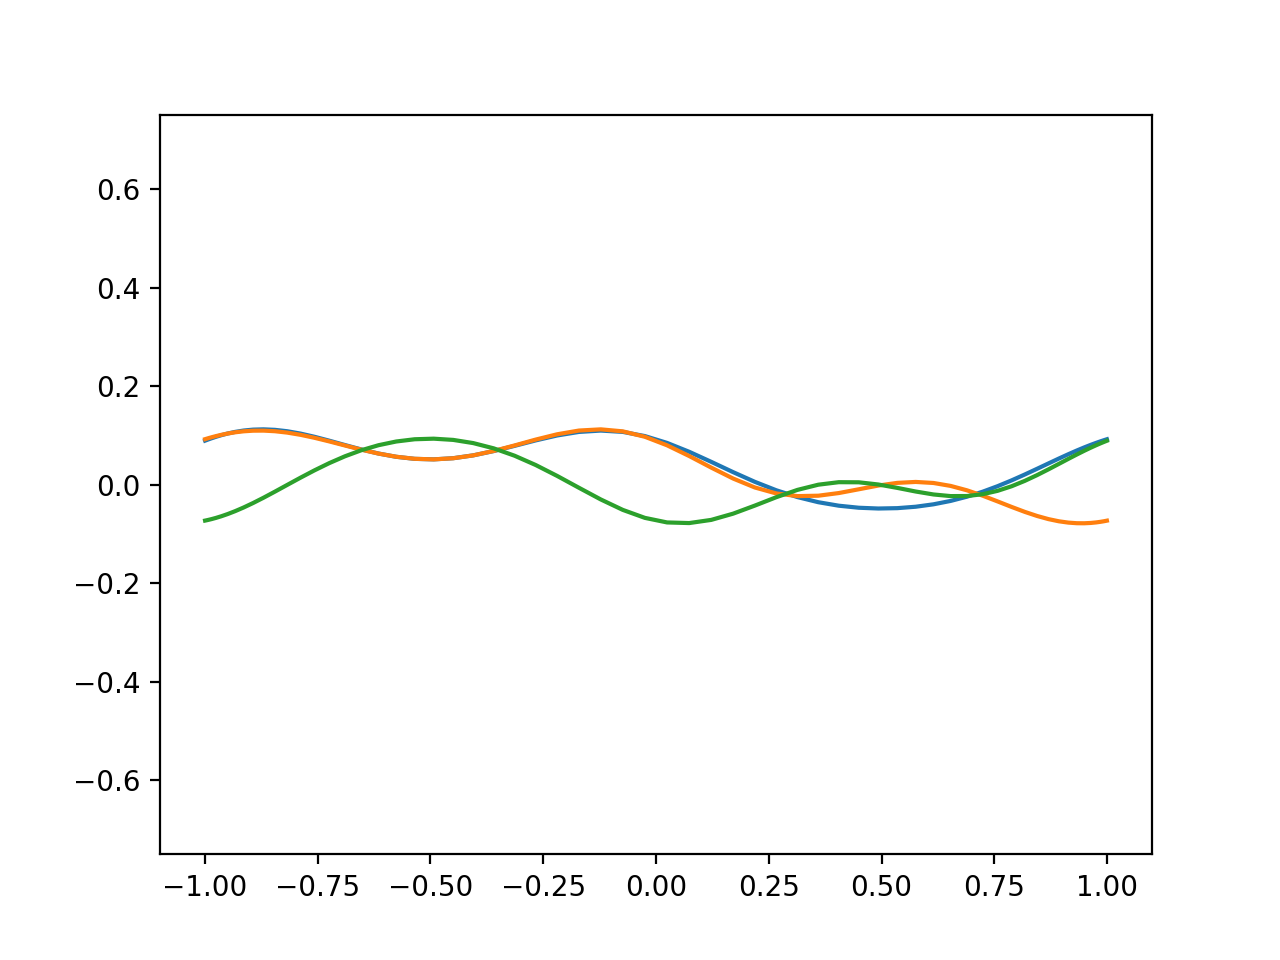

In [3]:
#Evolution of the nonlinear Schrödinger equation on a simple triangle
#network, simulated by coupling the boundaries of different fields on
#a 1D Chebyshev segment. A soliton initially isolated to one segment
#scatters at the vertices and fills the network over time.
N=64
dtype = np.complex128
x_basis = spectral.Chebyshev(N, interval=(-1, 1))
domain = spectral.Domain([x_basis])
x = x_basis.grid()
u1 = spectral.Field(domain, dtype=dtype)
u2 = spectral.Field(domain, dtype=dtype)
u3 = spectral.Field(domain, dtype=dtype)
    
u1.require_grid_space()
u1.data = np.exp(-(x-0.5)**2/0.01)

u2.require_grid_space()
u3.require_grid_space()

waves = NSE(domain, u1, u2, u3)

#waves.evolve(spectral.SBDF2, 2e-3, 200)

num_steps = 1000
dt = 2e-3

temp = spectral.Field(domain, dtype=dtype)
interval = temp.domain.grids()
interval = interval[0]

fig = plt.figure()
u1.require_grid_space()
u2.require_grid_space()
u3.require_grid_space()
p1, = plt.plot(interval, u1.data)
p2, = plt.plot(interval, u2.data)
p3, = plt.plot(interval, u3.data)
fig.canvas.draw()
plt.ylim([-0.75,0.75])

for i in range(num_steps//5):
    waves.evolve(spectral.SBDF2, dt, 5)
    
    u1.require_grid_space()
    u2.require_grid_space()
    u3.require_grid_space()
    p1.set_ydata(u1.data.real)
    p2.set_ydata(u2.data.real)
    p3.set_ydata(u3.data.real)
    fig.canvas.draw()

<IPython.core.display.Javascript object>


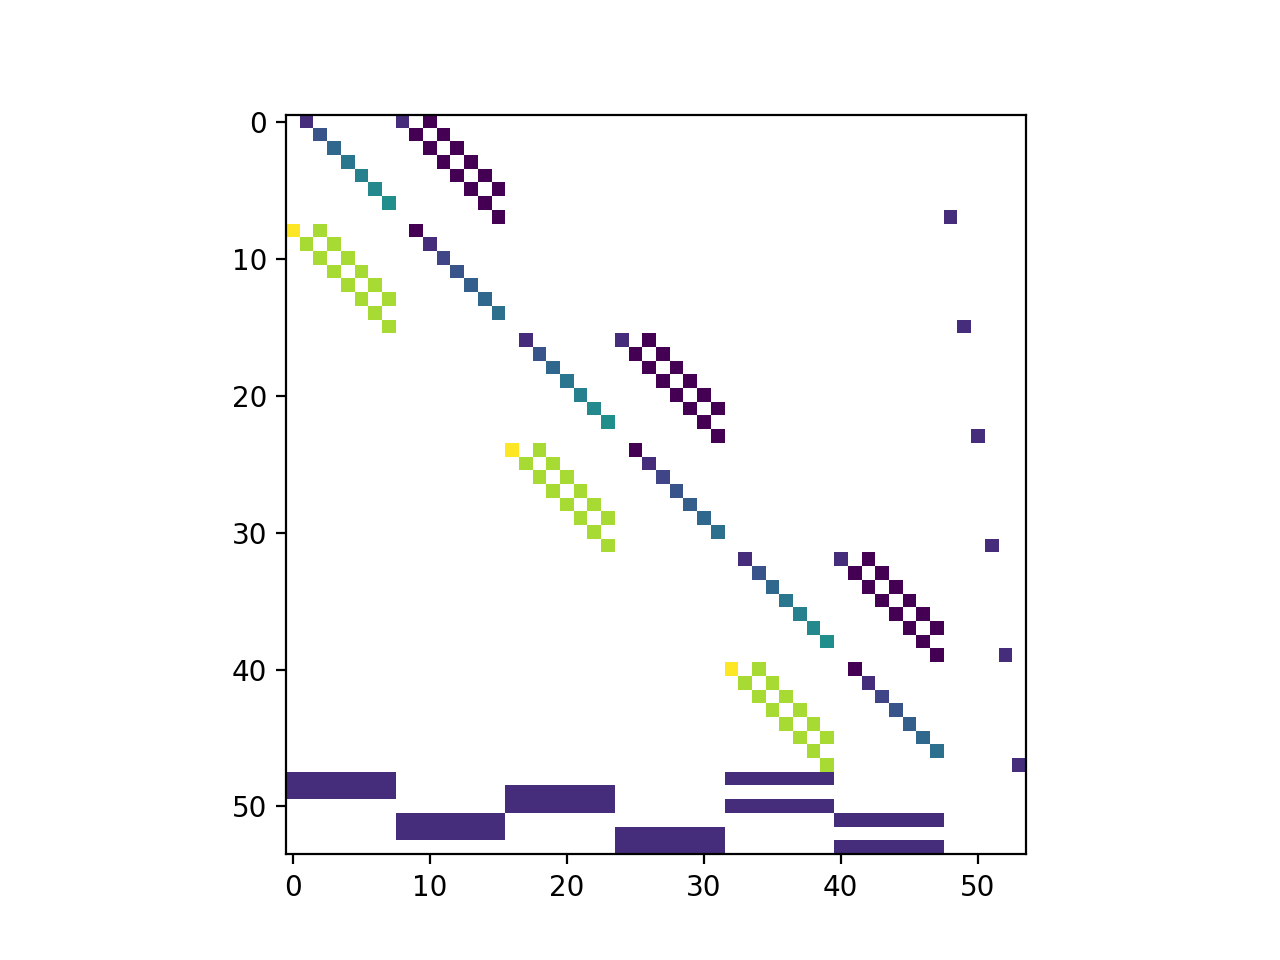

In [4]:
#visualization of matrix M/dt + L with low resolution (N=8)
N=8
dtype = np.complex128
x_basis = spectral.Chebyshev(N, interval=(-1, 1))
domain = spectral.Domain([x_basis])
x = x_basis.grid()
u1 = spectral.Field(domain, dtype=dtype)
u2 = spectral.Field(domain, dtype=dtype)
u3 = spectral.Field(domain, dtype=dtype)
    
u1.require_grid_space()
u1.data = np.exp(-(x-0.5)**2/0.01)

u2.require_grid_space()
u3.require_grid_space()

waves = NSE(domain, u1, u2, u3)
dt = 1e-2
LHS = waves.problem.pencils[0].M/dt + waves.problem.pencils[0].L
plt.figure()
plt.imshow(np.log(np.abs(LHS.A)))

In [5]:
#simulation test function, used for computing error
def NSE_simple_sim(N):
    dtype = np.complex128
    x_basis = spectral.Chebyshev(N, interval=(-1, 1))
    domain = spectral.Domain([x_basis])
    x = x_basis.grid()
    u1 = spectral.Field(domain, dtype=dtype)
    u2 = spectral.Field(domain, dtype=dtype)
    u3 = spectral.Field(domain, dtype=dtype)

    u1.require_grid_space()
    u1.data = np.exp(-(x-0.5)**2/0.01)

    u2.require_grid_space()
    u3.require_grid_space()

    waves = NSE(domain, u1, u2, u3)

    waves.evolve(spectral.SBDF2, 2e-3, 1000)
    u1.require_grid_space()
    return u1

<IPython.core.display.Javascript object>


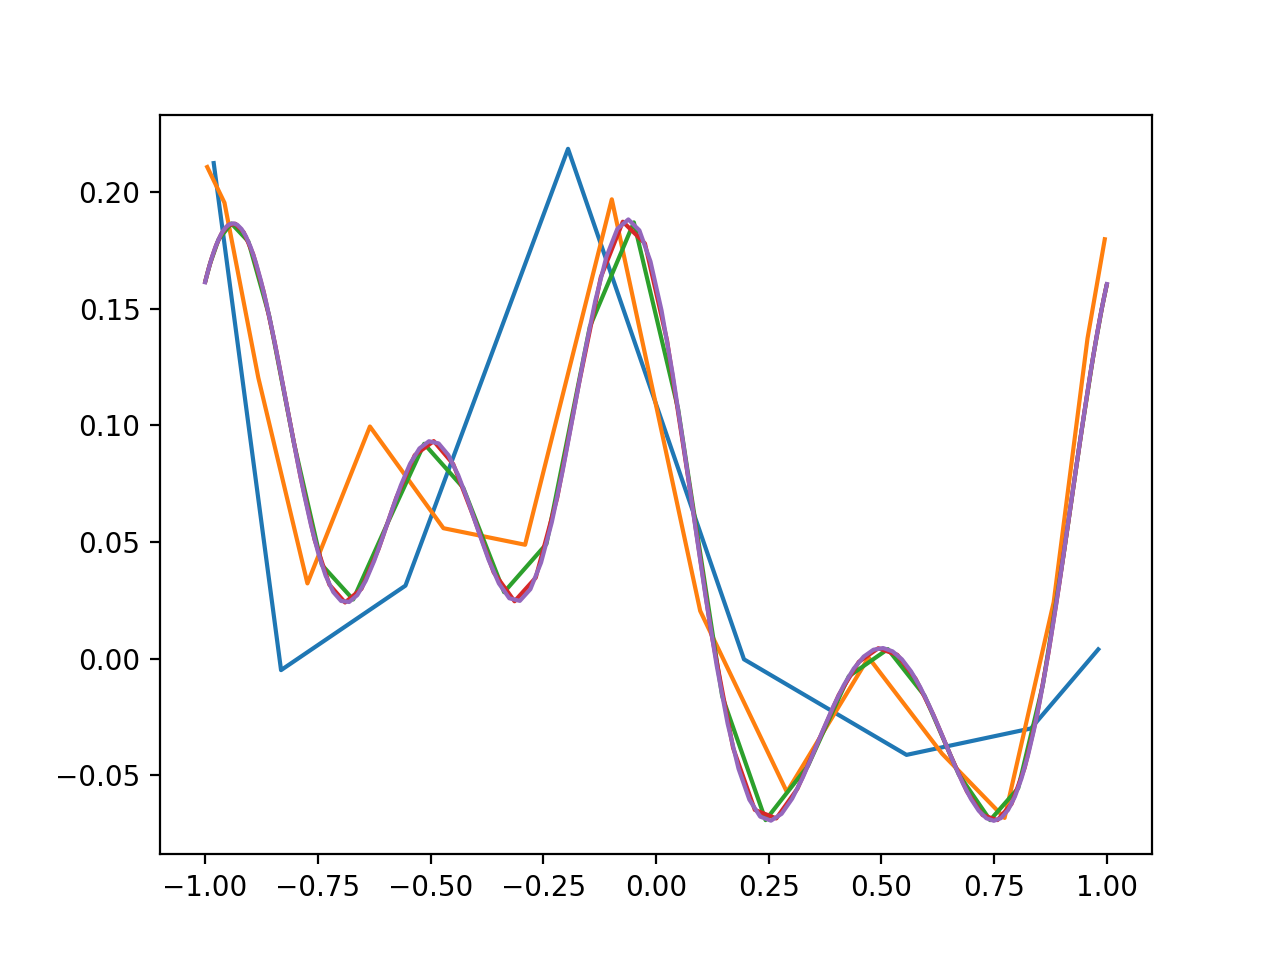

In [6]:
#solution of u1 at T = 2 using N=8,16,32,64,128; N=8 is not accurate at all. As we increase N, the solutions converge 
#to the one produced by N=128
fig = plt.figure()
sol = NSE_simple_sim(128)
l=[8,16,32,64,128]
for N in l:
    s = NSE_simple_sim(N)
    s.require_grid_space()
    x_basis = spectral.Chebyshev(N, interval=(-1, 1))
    domain = spectral.Domain([x_basis])
    temp = spectral.Field(domain, dtype=np.complex128)
    interval = temp.domain.grids()
    interval = interval[0]
    plt.plot(interval,s.data)


In [7]:
#compute error (in max norm) with different resolution N=8,16,32,64,128. Reference solution is provided by N=256
error = [0,0,0,0,0]

sol = NSE_simple_sim(256)

l=[8,16,32,64,128]
for i in range(len(l)):
    s = NSE_simple_sim(l[i])
    rate = 256//l[i]
    s.require_coeff_space()
    s.require_grid_space(scales=rate)
    sol.require_grid_space()
    error[i] = np.max(np.abs(sol.data-s.data))

<IPython.core.display.Javascript object>


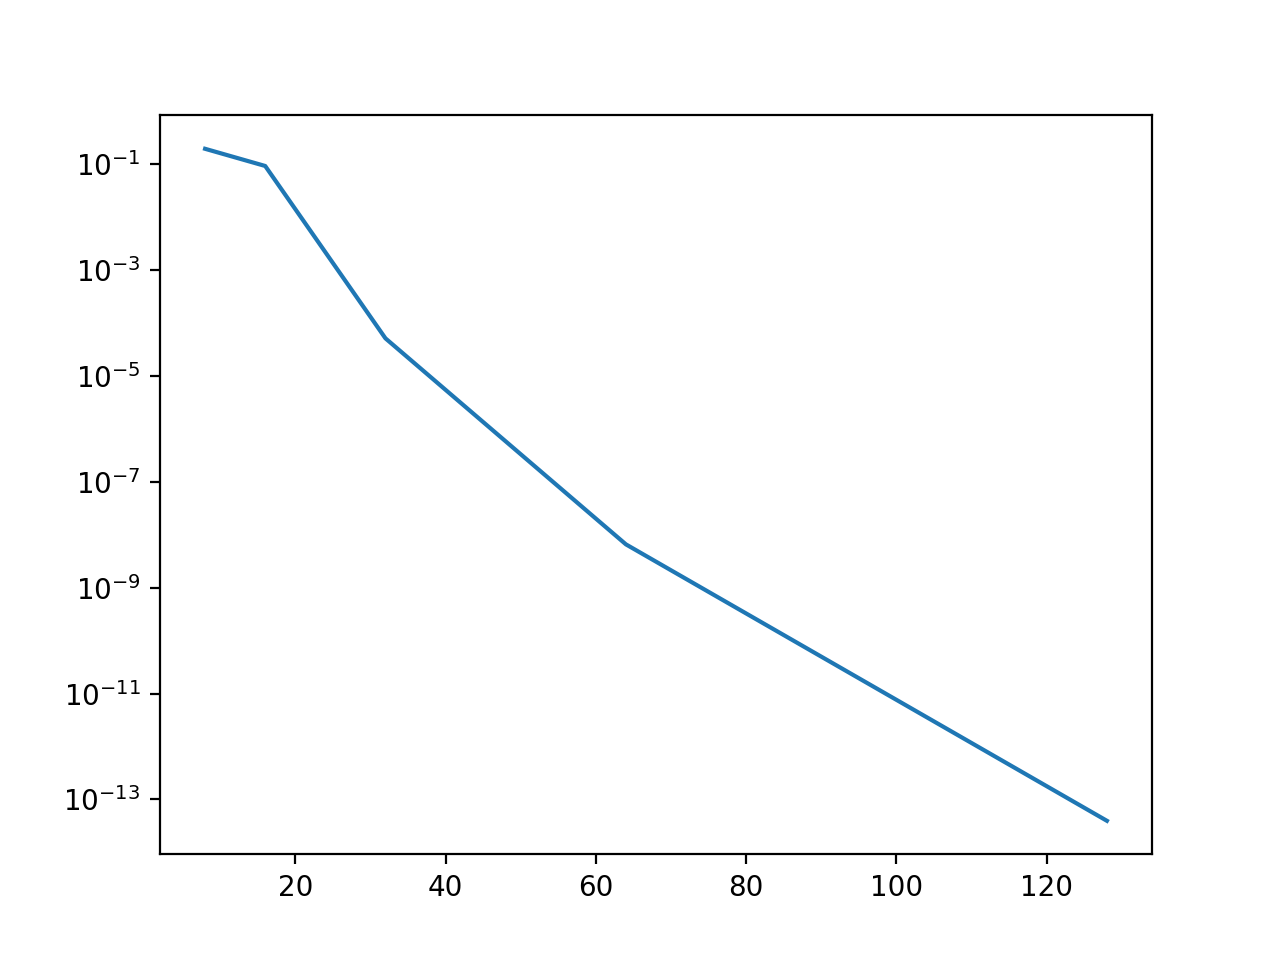

In [8]:
#The error goes to 0 exponentially.
fig2 = plt.figure()
plt.plot([8,16,32,64,128],error)  
plt.yscale('log')

2. More complex network

In [9]:
#class for Nonlinear Schrödinger Network
class NSE_complex:

    def __init__(self, domain, u1):
        self.domain = domain
        self.dtype = dtype = np.complex128
        E = 11
        self.u = []
        self.ux = []
        self.u_RHS = []
        self.ux_RHS = []
        
        for i in range(E):
            self.u.append(spectral.Field(domain, dtype=dtype))
            self.ux.append(spectral.Field(domain, dtype=dtype))
            self.u_RHS.append(spectral.Field(domain, dtype=dtype))
            self.ux_RHS.append(spectral.Field(domain, dtype=dtype))
        
        self.u[0].require_grid_space()
        self.u[0].data = u1.data 

        Vector = []
        Rhs = []
        for i in range(E):
            Vector.append(self.u[i])
            Vector.append(self.ux[i])
            Rhs.append(self.u_RHS[i])
            Rhs.append(self.ux_RHS[i])
        
        self.problem = spectral.InitialValueProblem(domain, Vector, Rhs, num_BCs=2*E, dtype=np.complex128)
        
        prob = self.problem.pencils[0]
        
        self.N = N = domain.bases[0].N
        Z = np.zeros((N, N))
        
        diag = np.arange(N-1)+1
        D = sparse.diags(diag, offsets=1)
        length=domain.bases[0].interval[1]-domain.bases[0].interval[0]
        D = (2/length)*D
        
        self.D = D

        diag0 = np.ones(N)/2
        diag0[0] = 1
        diag2 = -np.ones(N-2)/2
        self.C = C = sparse.diags((diag0, diag2), offsets=(0,2))
        
        # M matrix
        M = sparse.csr_matrix((2*E*N+2*E,2*E*N+2*E),dtype=np.complex128)
        
        for i in range(E):
            M[(2*i+1)*N:(2*i+2)*N, 2*i*N:(2*i+1)*N] = 1j*C
        prob.M = M
        
        # L matrix
        BC_rows1 = np.zeros((1, 2*N))
        BC_rows2 = np.zeros((1, 2*N))
        BC_rows3 = np.zeros((1, 2*N))
        BC_rows4 = np.zeros((1, 2*N))
        i = np.arange(N)
        BC_rows1[0, :N] = (-1)**i
        BC_rows2[0, :N] = (+1)**i
        BC_rows3[0, N:2*N] = (-1)**i
        BC_rows4[0, N:2*N] = (+1)**i
        
        BC_rows = np.zeros((2*E, 2*E*N))
        
        #v1(2bc)
        BC_rows[0, :2*N] = BC_rows1
        BC_rows[0, 12*N:14*N] = -BC_rows2
        
        BC_rows[1, :2*N] = -BC_rows3
        BC_rows[1, 12*N:14*N] = BC_rows4
        
        #v2(3bc)
        BC_rows[2, :2*N] = BC_rows2
        BC_rows[2, 2*N:4*N] = -BC_rows1
        
        BC_rows[3, :2*N] = BC_rows2
        BC_rows[3, 14*N:16*N] = -BC_rows1
        
        BC_rows[4, :2*N] = BC_rows4
        BC_rows[4, 2*N:4*N] = -BC_rows3
        BC_rows[4, 14*N:16*N] = -BC_rows3
        
        
        #v3(4bc)
        BC_rows[5, 10*N:12*N] = BC_rows2
        BC_rows[5, 12*N:14*N] = -BC_rows1
        
        BC_rows[6, 10*N:12*N] = BC_rows2
        BC_rows[6, 14*N:16*N] = -BC_rows2
        
        BC_rows[7, 10*N:12*N] = BC_rows2
        BC_rows[7, 16*N:18*N] = -BC_rows1
        
        BC_rows[8, 10*N:12*N] = BC_rows4
        BC_rows[8, 12*N:14*N] = -BC_rows3
        BC_rows[8, 14*N:16*N] = BC_rows4
        BC_rows[8, 16*N:18*N] = -BC_rows3
        
        #v4(4bc)
        BC_rows[9, 2*N:4*N] = BC_rows2
        BC_rows[9, 4*N:6*N] = -BC_rows1
        
        BC_rows[10, 2*N:4*N] = BC_rows2
        BC_rows[10, 16*N:18*N] = -BC_rows2
        
        BC_rows[11, 2*N:4*N] = BC_rows2
        BC_rows[11, 18*N:20*N] = -BC_rows2
        
        BC_rows[12, 2*N:4*N] = BC_rows4
        BC_rows[12, 4*N:6*N] = -BC_rows3
        BC_rows[12, 16*N:18*N] = BC_rows4
        BC_rows[12, 18*N:20*N] = BC_rows4
        
        #v5(4bc)
        BC_rows[13, 8*N:10*N] = BC_rows2
        BC_rows[13, 10*N:12*N] = -BC_rows1
        
        BC_rows[14, 8*N:10*N] = BC_rows2
        BC_rows[14, 18*N:20*N] = -BC_rows1
        
        BC_rows[15, 8*N:10*N] = BC_rows2
        BC_rows[15, 20*N:22*N] = -BC_rows2
        
        BC_rows[16, 8*N:10*N] = BC_rows4
        BC_rows[16, 10*N:12*N] = -BC_rows3
        BC_rows[16, 18*N:20*N] = -BC_rows3
        BC_rows[16, 20*N:22*N] = BC_rows4
        
        #v6(3bc)
        BC_rows[17, 4*N:6*N] = BC_rows2
        BC_rows[17, 6*N:8*N] = -BC_rows1
        
        BC_rows[18, 4*N:6*N] = BC_rows2
        BC_rows[18, 20*N:22*N] = -BC_rows1
        
        BC_rows[19, 4*N:6*N] = BC_rows4
        BC_rows[19, 6*N:8*N] = -BC_rows3
        BC_rows[19, 20*N:22*N] = -BC_rows3
        
        #v7(2bc)
        BC_rows[20, 6*N:8*N] = BC_rows2
        BC_rows[20, 8*N:10*N] = -BC_rows1
        
        BC_rows[21, 6*N:8*N] = BC_rows4
        BC_rows[21, 8*N:10*N] = -BC_rows3
    
        

        cols = np.zeros((2*E*N,2*E))
        for i in range(2*E):
            cols[(i+1)*N-1, i] = 1
        
        corner = np.zeros((2*E,2*E))

        Z = np.zeros((N, N))
        #Zlarge = np.zeros((2*N,2*N))
        L = sparse.bmat([[D, -C],
                         [Z, 0.5*D]])
        L = sparse.block_diag((L,L,L,L,L,L,L,L,L,L,L))
        L = sparse.bmat([[      L,   cols],
                         [BC_rows, corner]])
        L = L.tocsr()
        prob.L = L
        self.t = 0
        
        for i in range(E):
            self.u[i].require_coeff_space()
            self.ux[i].require_coeff_space()
            self.ux[i].data = self.D @ self.u[i].data
            self.ux[i].data = spla.spsolve(self.C,self.ux[i].data)
            

    def evolve(self, timestepper, dt, num_steps):
        ts = timestepper(self.problem)
        D = self.D
        BC_func = lambda t: [0 for i in range(22)]

        for i in range(num_steps):
            
            for k in range(11):
                
                self.u[k].require_coeff_space()
                self.ux[k].require_coeff_space()           
                self.ux_RHS[k].require_coeff_space()            
                self.u[k].require_grid_space(scales=3/2)
                self.ux_RHS[k].require_grid_space(scales=3/2)            
                self.ux_RHS[k].data = -self.u[k].data*np.power(np.abs(self.u[k].data),2)
           
                self.ux_RHS[k].require_coeff_space()
                self.ux_RHS[k].data = self.C @ self.ux_RHS[k].data
                self.u[k].require_coeff_space()
                self.ux[k].require_coeff_space()
                        
            
            ts.step(dt, BC_func(self.t))
            self.t += dt

<IPython.core.display.Javascript object>


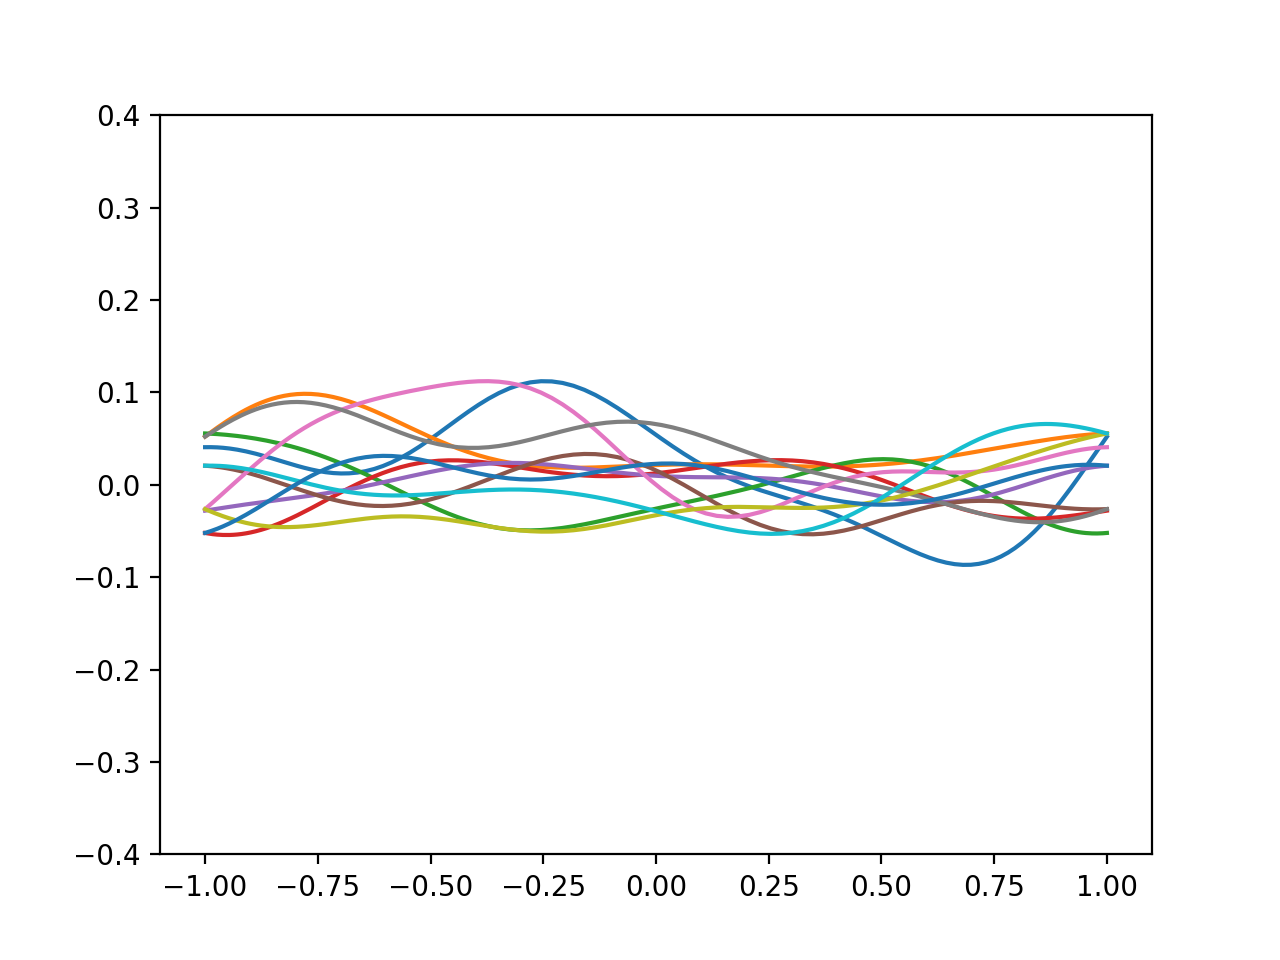

In [10]:
#Evolution of the nonlinear Schrödinger equation on a more complex triangle
#network, simulated by coupling the boundaries of different fields on
#a 1D Chebyshev segment. A soliton initially isolated to one segment
#scatters at the vertices and fills the network over time.
N=128
dtype = np.complex128
x_basis = spectral.Chebyshev(N, interval=(-1, 1))
domain = spectral.Domain([x_basis])
x = x_basis.grid()
u1 = spectral.Field(domain, dtype=dtype)
    
u1.require_grid_space()
u1.data = np.exp(-(x-0.5)**2/0.01)

waves = NSE_complex(domain, u1)

#waves.evolve(spectral.SBDF2, 2e-3, 200)

num_steps = 1000
dt = 2e-3

temp = spectral.Field(domain, dtype=dtype)
interval = temp.domain.grids()
interval = interval[0]

fig = plt.figure()

waves.u[0].require_grid_space()

p = []
for i in range(11):
    ptemp, = plt.plot(interval, waves.u[i].data)
    p.append(ptemp)

fig.canvas.draw()
plt.ylim([-0.4,0.4])

for i in range(num_steps//5):
    waves.evolve(spectral.SBDF2, dt, 5)
    
    for i in range(11):
        waves.u[i].require_grid_space()
        p[i].set_ydata(waves.u[i].data.real)
    fig.canvas.draw()

<IPython.core.display.Javascript object>


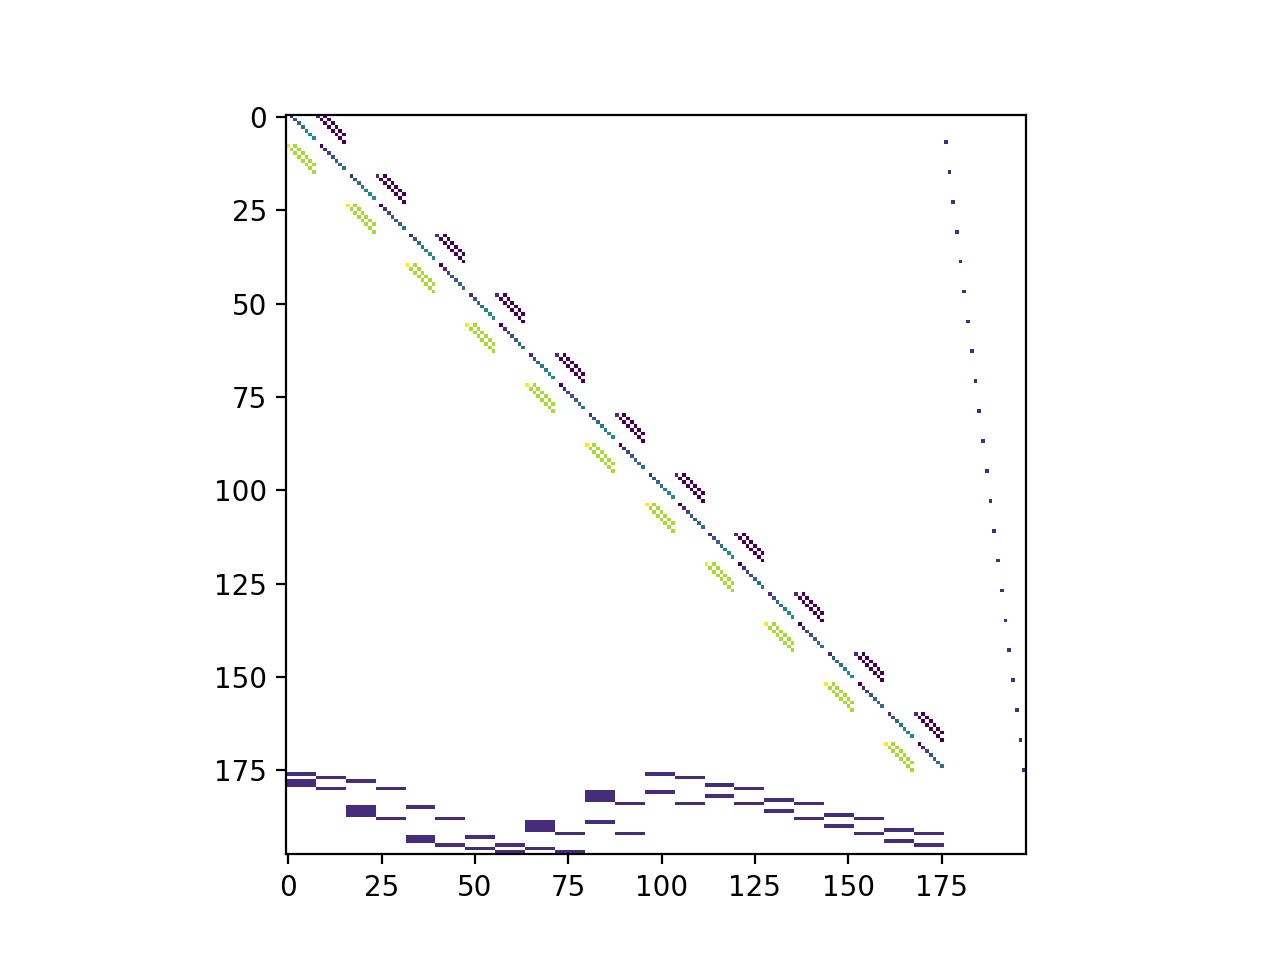

In [11]:
#visualization of matrix M/dt + L with low resolution (N=8)
N=8
dtype = np.complex128
x_basis = spectral.Chebyshev(N, interval=(-1, 1))
domain = spectral.Domain([x_basis])
x = x_basis.grid()
u1 = spectral.Field(domain, dtype=dtype)
    
u1.require_grid_space()
u1.data = np.exp(-(x-0.5)**2/0.01)

waves = NSE_complex(domain, u1)
dt = 1e-2
LHS = waves.problem.pencils[0].M/dt + waves.problem.pencils[0].L
plt.figure()
plt.imshow(np.log(np.abs(LHS.A)))

In [13]:
#simulation test function, used for computing error
def NSE_complex_sim(N):
    dtype = np.complex128
    x_basis = spectral.Chebyshev(N, interval=(-1, 1))
    domain = spectral.Domain([x_basis])
    x = x_basis.grid()
    u1 = spectral.Field(domain, dtype=dtype)
    
    u1.require_grid_space()
    u1.data = np.exp(-(x-0.5)**2/0.01)

    waves = NSE_complex(domain, u1)

    waves.evolve(spectral.SBDF2, 2e-3, 1000)
    waves.u[0].require_grid_space()
    return waves.u[0]

<IPython.core.display.Javascript object>


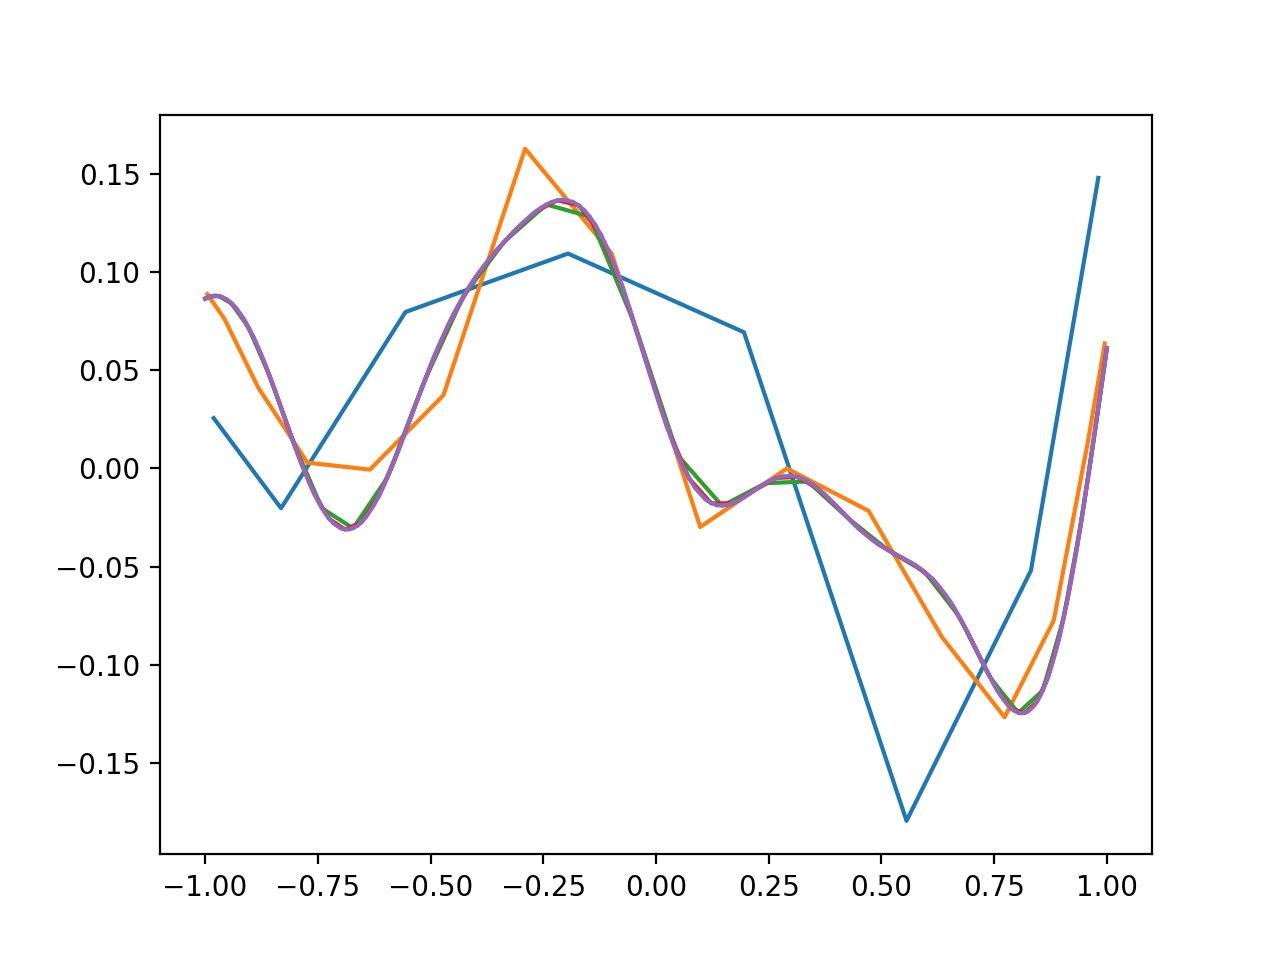

In [14]:
#solution of u1 at T = 2 using N=8,16,32,64,128; N=8 is not accurate at all. As we increase N, the solutions converge 
#to the one produced by N=128
fig = plt.figure()
l=[8,16,32,64,128]
for N in l:
    s = NSE_complex_sim(N)
    s.require_grid_space()
    x_basis = spectral.Chebyshev(N, interval=(-1, 1))
    domain = spectral.Domain([x_basis])
    temp = spectral.Field(domain, dtype=np.complex128)
    interval = temp.domain.grids()
    interval = interval[0]
    plt.plot(interval,s.data)

In [15]:
#compute error (in max norm) with different resolution N=8,16,32,64,128. Reference solution is provided by N=256
error = [0,0,0,0,0]

sol = NSE_complex_sim(256)

l=[8,16,32,64,128]
for i in range(len(l)):
    s = NSE_complex_sim(l[i])
    rate = 256//l[i]
    s.require_coeff_space()
    s.require_grid_space(scales=rate)
    sol.require_grid_space()
    error[i] = np.max(np.abs(sol.data-s.data))

<IPython.core.display.Javascript object>


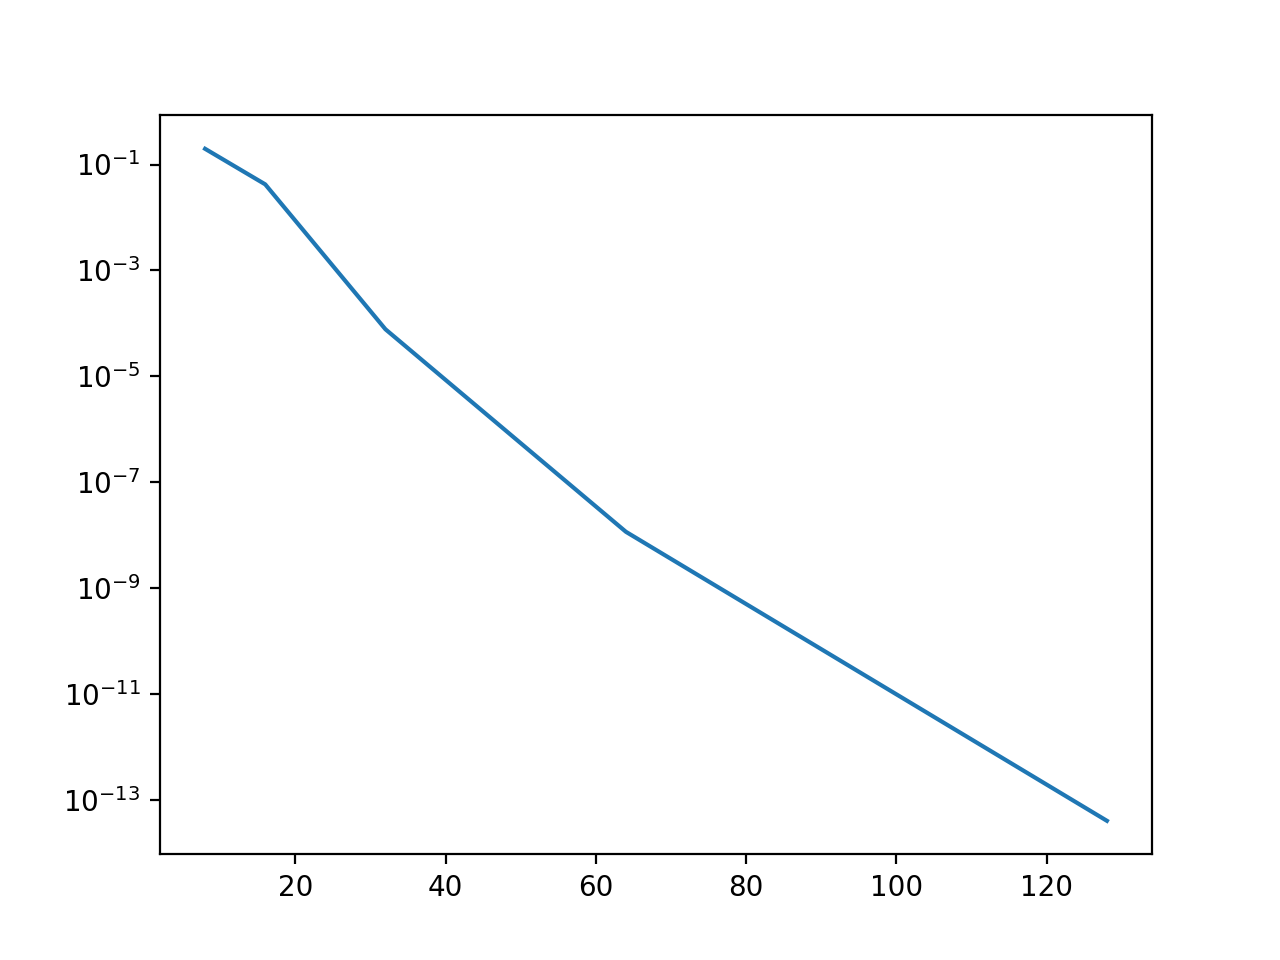

In [16]:
#The error goes to 0 exponentially.
fig2 = plt.figure()
plt.plot([8,16,32,64,128],error)  
plt.yscale('log')